In [1]:
import sys
sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

from source.common import *
from source.Calibration import CalibrationProblem
from source.DataGenerator import OnePointSpectraDataGenerator

In [2]:
####################################
### Configuration
####################################

config = {
    'type_EddyLifetime' :   'tauNet',  ### 'const', TwoThird', 'Mann', 'tauNet'
    'type_PowerSpectra' :   'RDT', ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    'nlayers'           :   2,
    'hidden_layer_size' :   10,
    # 'nModes'            :   5, ### number of modes in the rational function in tauNet ### deprecated
    'learn_nu'          :   False, ### NOTE: Experiment 1: False, Experiment 2: True
    'plt_tau'           :   True,
    'tol'               :   1.e-3, ### not important
    'lr'                :   1,     ### learning rate
    'penalty'           :   1.e-1,
    'regularization'    :   1.e-1,
    'nepochs'           :   200,
    'curves'            :   [0,1,2,3],
    'data_type'         :   'Kaimal', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    'Uref'              :   10, # m/s
    'zref'              :   90, #m
    'domain'            :   np.logspace(-3, 3, 20), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    'noisy_data'        :   0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    'output_folder'     :   '/Users/gdeskos/work_in_progress/WindGenerator/data/'
}
pb = CalibrationProblem(**config)

In [6]:
####################################
### Initialize Parameters
####################################

#Calculating turbulence parameters according to IEC standards
# we assume a hub height z=150m corresponding to the IEA 15MW wind turbine hub height
zref=config['zref']; # Hub height in meters
Uref=config['Uref']; # Average Hub height velocity in m/s
Iref = 0.14
sigma1=Iref*(0.75*Uref+5.6)
Lambda1=42; # Longitudinal turbulence scale parameter at hub height


#Mann model parameters
#Gamma = 3.9
#sigma = 0.55*sigma1
#L=0.8*Lambda1;


z0=0.1
ustar=0.41*Uref/log(zref/z0)

L     = 0.59*zref
Gamma = 3.9
sigma = 6.4/zref**(2./3.)

print(L,Gamma,sigma)

sigma = sigma * L**(5./3.)

parameters = pb.parameters
parameters[:3] = [log(L), log(Gamma), log(sigma)] #All of these parameters are positive 
#so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = config['domain'] #np.logspace(-1, 2, 20)
DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

### Data perturbation
data_noise_magnitude = config['noisy_data']
if data_noise_magnitude:
    Data[1][:] *= np.exp(np.random.normal(loc=0, scale=data_noise_magnitude, size=Data[1].shape))

DataValues = Data[1]

53.099999999999994 3.9 0.31867767086628734


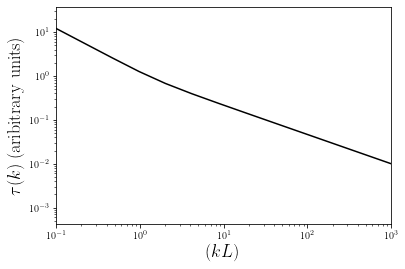

In [7]:
IECtau=MannEddyLifetime(k1_data_pts*L)
plt.figure(1)
plt.loglog(k1_data_pts*L,IECtau,'k')
plt.xlim(0.1,1000)
plt.ylabel(r'$\tau(k)$ (aribitrary units)',fontsize=18)
plt.xlabel(r'$(kL)$',fontsize=18)
plt.savefig('tau.png')

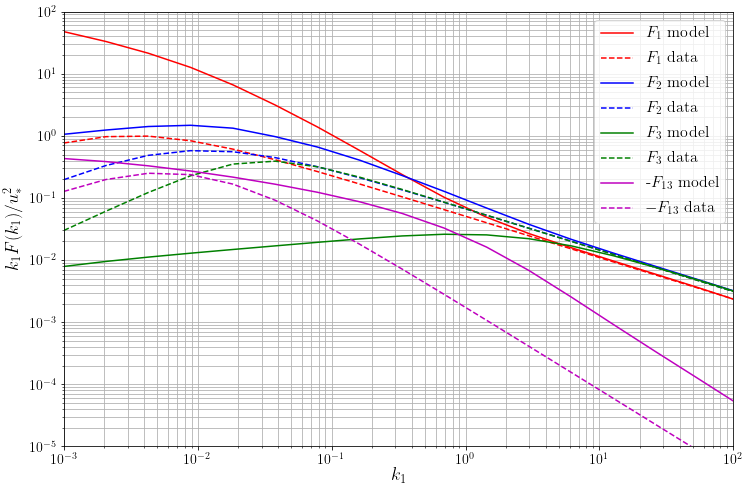

In [8]:
####################################
### Just plot
####################################

kF = pb.eval(k1_data_pts)
plt.figure(1,figsize=(12,8))
clr=['red','blue','green']
for i in range(3):
    plt.plot(k1_data_pts, kF[i], '-', color=clr[i], label=r'$F_{0:d}$ model'.format(i+1))
    plt.plot(k1_data_pts, DataValues[:,i,i], '--',color=clr[i],label=r'$F_{0:d}$ data'.format(i+1) )#, label=r'$F_{0:d}$ data'.format(i+1))
plt.plot(k1_data_pts, -kF[3], '-m', label=r'-$F_{13}$ model')
plt.plot(k1_data_pts, -DataValues[:,0,2], '--m', label=r'$-F_{13}$ data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_1$',fontsize=18)
plt.xlim(0.001,100)
plt.ylim(0.00001,100)


plt.ylabel(r'$k_1 F(k_1)/u_\ast^2$',fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(which='both')
plt.savefig(config['output_folder']+'initial_Kaimal_guess.pdf',dpi=100)

In [ ]:
####################################
### Calibrate
####################################
opt_params = pb.calibrate(Data=Data, **config)#, OptimizerClass=torch.optim.RMSprop)


Callibrating MannNet...
Initial loss:  2.62257018447043

-> Epoch 0

pen =  0.0002194469996188438
reg =  0.004116800660086497
loss  =  2.626906432130135
pen =  0.00023912626340237737
reg =  0.004082336386461254
loss  =  2.1329300786826226
pen =  0.0002840186619571276
reg =  0.004038542575243497
loss  =  1.7169688909129206
pen =  0.000382663782750772
reg =  0.0039984609078164025
loss  =  0.674986190570433
pen =  0.00023978160248813355
reg =  0.004036190835799203
loss  =  0.2703182408344248
pen =  0.00022479911379006683
reg =  0.004066849552861034
loss  =  0.22775250408589928
pen =  0.00022820168227350812
reg =  0.004079972545440998
loss  =  0.22575902651796995
pen =  0.0002529152796978936
reg =  0.004167446396786691
loss  =  0.21755374121815743
pen =  0.0003148501713343945
reg =  0.004364170430000611
loss  =  0.20614718533043508
pen =  0.0004868780497246537
reg =  0.004737150941546159
loss  =  0.19472274462678643
pen =  0.0006022807704230836
reg =  0.0047892452721743405
loss  =  0.1922

pen =  0.00038857262136728565
reg =  0.014467275799927175
loss  =  0.12925641843351146
pen =  0.00039988937931851156
reg =  0.015553201121157387
loss  =  0.1282951089359626
pen =  0.0005530284739045832
reg =  0.016547685083116652
loss  =  0.12737631704404112
pen =  0.0004912455902917836
reg =  0.018623636028315054
loss  =  0.12649161285367988
pen =  0.0007902546966375641
reg =  0.01875225412215571
loss  =  0.1255894289994525
pen =  0.0008275665345206705
reg =  0.019245905221968743
loss  =  0.12488774900653571
pen =  0.0005465020348263468
reg =  0.019971445506858553
loss  =  0.12188066287062407
pen =  1.3772301189863732e-05
reg =  0.019019901366315324
loss  =  0.12366089751876297
pen =  0.00016675540323028072
reg =  0.01927706960642884
loss  =  0.12015504999021226
pen =  0.00033791372858359777
reg =  0.01723457368117985
loss  =  0.11736070258640689
pen =  0.0003110645906219309
reg =  0.01403153578571023
loss  =  0.11454989704679851
pen =  0.001883756729433684
reg =  0.013433208283022652

pen =  0.00016267318480728808
reg =  0.01710018273268955
loss  =  0.10648670580378337
pen =  0.00022698828619105478
reg =  0.01650049791141674
loss  =  0.10624666188910385
pen =  0.0001972426400825627
reg =  0.01624034723494848
loss  =  0.10615558587790688
pen =  0.00018990587711504304
reg =  0.016033790016873696
loss  =  0.10603733785998293
pen =  0.0002347492153031139
reg =  0.0159877371295244
loss  =  0.10570374117457848
pen =  0.00021328508455392667
reg =  0.01579396978888849
loss  =  0.10507097954476756
pen =  0.0002066698826422154
reg =  0.01555860414129865
loss  =  0.10478652220969853
pen =  0.0006747071041687743
reg =  0.015537151068392938
loss  =  0.1048674924932807
pen =  0.0003729766137884644
reg =  0.015547069703560979
loss  =  0.10465238995319191
pen =  0.0002932950554320863
reg =  0.015602559086435736
loss  =  0.10425015185565618
pen =  0.00013749556827403773
reg =  0.016188425800411407
loss  =  0.10377882151315812
pen =  0.00029361990181106545
reg =  0.018258827082932975

pen =  0.00029910048339714464
reg =  0.01582663039579769
loss  =  0.10154186183588917
pen =  0.00028519336392740974
reg =  0.01585591031257699
loss  =  0.1014993574507159
pen =  0.00025413332934056337
reg =  0.015977055733966558
loss  =  0.10143462643135517
pen =  0.0002680811273871213
reg =  0.016118949202425664
loss  =  0.10138619868727555
pen =  0.00027627167552735885
reg =  0.01670748995770871
loss  =  0.1012821487821251
pen =  0.0002785250269285143
reg =  0.016834676802596517
loss  =  0.10112778056372435
pen =  0.000496200994925083
reg =  0.01701799697986532
loss  =  0.1011098452091792
pen =  0.0003785283169847559
reg =  0.01692126246818675
loss  =  0.10102718400276008
pen =  0.0003281285832319271
reg =  0.01700175743944791
loss  =  0.1008310474844234
pen =  0.0003988448853882384
reg =  0.01977469432514358
loss  =  0.10498138336693907
pen =  0.00028663863562480195
reg =  0.01754205667490914
loss  =  0.10060847981280319
pen =  0.00023372890195221734
reg =  0.01833624721272192
loss 

pen =  0.00017628497660996832
reg =  0.0240451911227783
loss  =  0.09539491015006399
pen =  0.0001037406974922862
reg =  0.025606313992783975
loss  =  0.09482798614348881
pen =  0.00018050810921455953
reg =  0.024707424642073216
loss  =  0.09446520755493475
pen =  0.00012478926699994186
reg =  0.025463678212835735
loss  =  0.09415275235138192
pen =  8.706590575623062e-05
reg =  0.027211079845066474
loss  =  0.09423749387889369
pen =  0.00011900622378989076
reg =  0.02614070938753395
loss  =  0.09395627483538861
pen =  0.00017815578853029213
reg =  0.026925150851974736
loss  =  0.09379589203429982
pen =  0.0001910127880021017
reg =  0.026909225951694184
loss  =  0.09375559126203048
pen =  0.0002667138852014606
reg =  0.027139955734976663
loss  =  0.09366738846784312
pen =  0.00015597103326942755
reg =  0.027676531734907663
loss  =  0.09362009287372981
pen =  0.000165660365979897
reg =  0.027220676058943707
loss  =  0.09353387759005499
pen =  0.0002263674954619831
reg =  0.02616371022330

pen =  0.0001804993291014846
reg =  0.027717619132502477
loss  =  0.09240342176292739
pen =  0.00016597292625880725
reg =  0.027534429795108048
loss  =  0.09232325044427286
pen =  0.0001648179503732558
reg =  0.027343294687177052
loss  =  0.09227015628001287
pen =  0.00015743699859298323
reg =  0.02734502500838546
loss  =  0.0921597732354699
pen =  0.00010040300152309001
reg =  0.027412228096643867
loss  =  0.0920699470162869
pen =  0.00017002323261890336
reg =  0.027265511425280237
loss  =  0.0919881231327863
pen =  0.0001628153350907837
reg =  0.027623914644575732
loss  =  0.09191196169516555
pen =  8.048340852648824e-05
reg =  0.02819059766884731
loss  =  0.09188153415762382
pen =  0.00011580461280356861
reg =  0.027966999204989698
loss  =  0.09184186134743214
pen =  0.00013117749206262937
reg =  0.027992732758526248
loss  =  0.09180749913012508
pen =  0.00014979594243851296
reg =  0.028111436602164825
loss  =  0.09174697719550559
pen =  0.0001687032139002316
reg =  0.02821879453170

pen =  0.00016816352263664922
reg =  0.028402140062737787
loss  =  0.09155282480525354
pen =  0.00016675274228605773
reg =  0.02828801900152963
loss  =  0.09154034876692156
pen =  0.00017334835079105585
reg =  0.028195639433404612
loss  =  0.0915165337201837
pen =  0.00016502272667414105
reg =  0.028234802278691646
loss  =  0.09150339376756789
pen =  0.00016638939943584453
reg =  0.028283676357177212
loss  =  0.09149456778571963
pen =  0.00016484279469095058
reg =  0.028386710310640675
loss  =  0.0914853444312949
pen =  0.00016569947253010494
reg =  0.02857833145998165
loss  =  0.09148884587361593
pen =  0.00016519069004075398
reg =  0.028452202639042013
loss  =  0.09147996175166849
pen =  0.00016332611616190997
reg =  0.02841719364123212
loss  =  0.09147512458552247
pen =  0.0001549389571332389
reg =  0.028318485723453343
loss  =  0.09146878238752543
pen =  0.00015544280580171173
reg =  0.02828174137826366
loss  =  0.09146072766468274
pen =  0.0001637562429957573
reg =  0.028372917075

pen =  0.0001741304781671162
reg =  0.028185603727043824
loss  =  0.09137235960558138
pen =  0.00017713257804838982
reg =  0.028203211565502317
loss  =  0.09136949971165592
pen =  0.0001789919136573648
reg =  0.028215145398784326
loss  =  0.09136483792860081
pen =  0.00016867765830986278
reg =  0.028240638304191257
loss  =  0.09136166374791466
pen =  0.00016520335880767872
reg =  0.02827725472853452
loss  =  0.09136117471467031
pen =  0.00016763369732962366
reg =  0.02823540053558843
loss  =  0.09135610824392344
pen =  0.0001641273306671498
reg =  0.028159754661011373
loss  =  0.09135626751931719
pen =  0.00016616476174430373
reg =  0.028203087348326952
loss  =  0.09135517366880909
pen =  0.00016339642672127784
reg =  0.028184659377394096
loss  =  0.09135026975829172
pen =  0.00015386196129011214
reg =  0.02806637967519364
loss  =  0.09134494086605027
pen =  0.0001559651159277925
reg =  0.028080631900390115
loss  =  0.09133021594794077
pen =  0.00016733676327605426
reg =  0.02818097769

pen =  0.00018199359401192394
reg =  0.02839270787607108
loss  =  0.09113386709716989
pen =  0.00019478470433318903
reg =  0.028454585148709678
loss  =  0.0911208491651878
pen =  0.0002015510875316547
reg =  0.028409400509213797
loss  =  0.0911091124893063
pen =  0.00019773972486866495
reg =  0.028471377772299328
loss  =  0.0911066147248643
pen =  0.00019072336342796932
reg =  0.02859475210837791
loss  =  0.09109454154156807
pen =  0.00023188920942476528
reg =  0.029107034158899092
loss  =  0.09110182174414577
pen =  0.00020540617407507195
reg =  0.028787469639486165
loss  =  0.09108688038131754
pen =  0.00020476240686816399
reg =  0.028712957322725965
loss  =  0.09107130168109875
pen =  0.00019546401683139038
reg =  0.028476722297123752
loss  =  0.09104307357229463
pen =  0.000203015634075437
reg =  0.028178910902321188
loss  =  0.09102391304341546
pen =  0.000214328980703622
reg =  0.028203934652540775
loss  =  0.0909619444721037
pen =  0.00027699883670553345
reg =  0.028163766776455

pen =  0.0005729585132749265
reg =  0.028518662743780822
loss  =  0.0897789793438504
pen =  0.0001346710907068884
reg =  6.278657200282833
loss  =  175.0719619056025
pen =  0.00034221065730284694
reg =  0.028501511100087376
loss  =  0.08993938748137936
pen =  0.0005179530549704632
reg =  0.028512449144619492
loss  =  0.08974637261263266
pen =  0.0004859983680657862
reg =  0.028178377666579702
loss  =  0.08932902897603008
pen =  7.093787703202114e-06
reg =  0.02736568340704658
loss  =  0.10827637219775041
pen =  0.0003217595911383887
reg =  0.028137352369881997
loss  =  0.0892192933078788
pen =  0.00021583600090984055
reg =  0.028047952686184204
loss  =  0.08949802648111611
pen =  0.0003567516368037769
reg =  0.028103494482057175
loss  =  0.08898345064029803
pen =  0.00043027103876923725
reg =  0.028355773789707297
loss  =  0.08805691980361492
pen =  0.0004297529793542549
reg =  0.028860963911653537
loss  =  0.09543432858868588
pen =  0.0005326207973198339
reg =  0.028387025713523452
lo

pen =  0.002288621511465548
reg =  0.028184281582318393
loss  =  0.08623381680942258
pen =  5.369466655788368e-05
reg =  0.025024685154383688
loss  =  0.18468320846267475
pen =  0.0018057783649322104
reg =  0.028102440439465914
loss  =  0.08677921708419735
pen =  0.002339360505076306
reg =  0.028176061558836465
loss  =  0.0862092885983273
pen =  6.217787043272947e-05
reg =  0.022854665435341467
loss  =  0.10274390636869245
pen =  0.0013310824193619774
reg =  0.02758456764440316
loss  =  0.08901055683964118
pen =  0.002347935202108485
reg =  0.028116136528999577
loss  =  0.08626432173874213
pen =  0.0024534131368819244
reg =  0.028154163081500913
loss  =  0.08616820050946394
pen =  0.001954018965764036
reg =  0.020921166761812878
loss  =  0.11275183915771361
pen =  0.0003995639279690994
reg =  0.026196643111739294
loss  =  0.09077346693885666
pen =  0.0022426370228928005
reg =  0.027960978294727018
loss  =  0.08662685751063257
pen =  0.0026005267670431995
reg =  0.02812436057519791
loss

pen =  0.0018024884864417147
reg =  0.02790064677578293
loss  =  0.08400574708654372
pen =  9.24044808141063e-05
reg =  0.028445139506716052
loss  =  0.08903068189304458
pen =  0.0009064646822084619
reg =  0.027988067433812536
loss  =  0.0849406506069407
pen =  0.0019066431722328634
reg =  0.027915798988907642
loss  =  0.0838731477168129
pen =  0.0006863795875950935
reg =  0.02736194398837879
loss  =  0.08683943677502276
pen =  0.0010005231992763286
reg =  0.027837015623969244
loss  =  0.08506358046894744
pen =  0.0019161584215322627
reg =  0.027914546756362426
loss  =  0.08386566870970286
pen =  0.0019722545158015847
reg =  0.027906753940930413
loss  =  0.08382282641489269
pen =  0.00040059431350638686
reg =  0.027388820778856238
loss  =  0.086574487766714
pen =  0.0019732721787750845
reg =  0.02786460186193206
loss  =  0.08372740406799252
pen =  0.00022982554706653686
reg =  0.026644400221019007
loss  =  0.08770745574435888
pen =  0.00190251082395121
reg =  0.027752338327982545
loss 

pen =  0.0018452046788089912
reg =  0.02764396087610123
loss  =  0.08337145845366442
pen =  0.00128781989498892
reg =  0.026080800924622918
loss  =  0.08328365132233741
pen =  0.0012303142713870536
reg =  0.02669367345910603
loss  =  0.08318921330996579
pen =  0.0015395052687527363
reg =  0.027045551516083222
loss  =  0.08292408772572146
pen =  0.031003442032435016
reg =  0.021211921420030266
loss  =  0.2651639021872072
pen =  0.0006155429817841587
reg =  0.02368857466517418
loss  =  0.10320148026931544
pen =  0.001253370761389779
reg =  0.02637772609499143
loss  =  0.08305498288545296
pen =  0.001484507760021468
reg =  0.026807172789311818
loss  =  0.08277475854356262
pen =  0.0012897658379707939
reg =  0.026430526809324697
loss  =  0.08271244922059812
pen =  0.0014043973557397865
reg =  0.026568044077691866
loss  =  0.08265681592376034
pen =  0.00044169471214322266
reg =  0.025335901592321276
loss  =  0.08523352444976842
pen =  0.0013538922345820523
reg =  0.02637846854235508
loss  =

pen =  0.000798180827440625
reg =  0.025925796253516837
loss  =  0.08205684232478284
pen =  0.00041456082213125176
reg =  0.025262054397607855
loss  =  0.08331067784194086
pen =  0.0007680085269879983
reg =  0.025805008100655825
loss  =  0.08200933871621124
pen =  0.0007996433095831857
reg =  0.025688422876072117
loss  =  0.08190474731858706
pen =  0.0005592606506678869
reg =  0.02531376795670194
loss  =  0.08244072093056809
pen =  0.0007804192581121722
reg =  0.025521107482341134
loss  =  0.0817865982795272
pen =  0.00039137226727608453
reg =  0.025378066338206235
loss  =  0.0833468671881527
pen =  0.0007802881097090615
reg =  0.02551543016665038
loss  =  0.08177850588730552
pen =  0.0007798256083779562
reg =  0.02550148389465049
loss  =  0.08175955390376516
pen =  0.00019048643791985854
reg =  0.02544424139718774
loss  =  0.08501141027374456
pen =  0.0007799149649505407
reg =  0.025500056984311945
loss  =  0.08175051747690674
pen =  0.0007595677187627392
reg =  0.025494157827362342
l

pen =  0.000779829669945303
reg =  0.025496301208527163
loss  =  0.08172750088580008
pen =  0.0005617641391284016
reg =  0.02551361004196422
loss  =  0.08252629819583762
pen =  0.0007667732305721854
reg =  0.025497457826473193
loss  =  0.08169744736553254
pen =  0.004818199392544502
reg =  0.02606230873563873
loss  =  0.10723539663779008
pen =  0.0005192808843039186
reg =  0.025605947711397077
loss  =  0.08408478832185738
pen =  0.0007546062681122448
reg =  0.025504430055086583
loss  =  0.08167374537978503
pen =  0.0008235045808624754
reg =  0.025457281106553094
loss  =  0.08156624694847349
pen =  0.0008340350327731834
reg =  0.025650594105586972
loss  =  0.08152203081229718
pen =  0.0006355732038835502
reg =  0.025853338033143
loss  =  0.08199243778169281
pen =  0.0008298560071793155
reg =  0.02567270175147628
loss  =  0.08150963752472784
pen =  0.0008128113795854443
reg =  0.02564345873614566
loss  =  0.08146773279846439
pen =  0.0007390724436482737
reg =  0.025491565922202378
loss  

pen =  0.0007054576101942035
reg =  0.024752173213164544
loss  =  0.08117035295593578
pen =  0.0007073171988739268
reg =  0.02468931634563453
loss  =  0.08114454309934471
pen =  0.0006956583341732105
reg =  0.024538699230140338
loss  =  0.0811530332010572
pen =  0.0007082125595846432
reg =  0.02461172293725697
loss  =  0.08111500479551884
pen =  0.0006992683620724515
reg =  0.024574928887845147
loss  =  0.08107369474955257
pen =  0.0007002924899455498
reg =  0.02454904521996397
loss  =  0.0810115311214949
pen =  0.0008093631767899932
reg =  0.024322266245304328
loss  =  0.08094155384390386
pen =  0.0006984936043743022
reg =  0.024435317980442815
loss  =  0.08132684439111446
pen =  0.0008126960563216101
reg =  0.024338694711484244
loss  =  0.08093398064985721
pen =  0.0007762050676993872
reg =  0.02438596596382615
loss  =  0.08090836896574045
pen =  0.0008032689944017509
reg =  0.024388009899856213
loss  =  0.08092314873200826
pen =  0.0007874665418189464
reg =  0.024386422058126002
los

pen =  0.0008024428332210003
reg =  0.024461256033673835
loss  =  0.08082137593084619
pen =  0.000951495829788642
reg =  0.024493256777822103
loss  =  0.0812643989080514
pen =  0.0008065520938163297
reg =  0.024462969116382845
loss  =  0.08084666086885871
pen =  0.0008028180532401917
reg =  0.024461417919748263
loss  =  0.08082382467071705
pen =  0.0008024794993220418
reg =  0.02446127144710175
loss  =  0.08082161145589942
pen =  0.0008024465004318961
reg =  0.024461257574152403
loss  =  0.08082139951076939
pen =  0.0008024431853422717
reg =  0.024461256181225247
loss  =  0.08082137819508085
pen =  0.0008024428685806397
reg =  0.024461256048428897
loss  =  0.08082137615683777
pen =  0.0008024428367591433
reg =  0.02446125603508821
loss  =  0.08082137595207609
pen =  0.0008024428337224522
reg =  0.024461256033815274
loss  =  0.08082137593253685
grad =  [ 6.07613625e-03  4.46897567e-04 -2.85068413e-03 -1.83744254e-01
 -6.39989615e-03 -1.19916549e-01  2.34447763e-04  1.39911171e-04
 -2.81

pen =  0.0008024428332210003
reg =  0.024461256033673835
loss  =  0.08082137593084619
pen =  0.000951495829788642
reg =  0.024493256777822103
loss  =  0.0812643989080514
pen =  0.0008065520938163297
reg =  0.024462969116382845
loss  =  0.08084666086885871
pen =  0.0008028180532401917
reg =  0.024461417919748263
loss  =  0.08082382467071705
pen =  0.0008024794993220418
reg =  0.02446127144710175
loss  =  0.08082161145589942
pen =  0.0008024465004318961
reg =  0.024461257574152403
loss  =  0.08082139951076939
pen =  0.0008024431853422717
reg =  0.024461256181225247
loss  =  0.08082137819508085
pen =  0.0008024428685806397
reg =  0.024461256048428897
loss  =  0.08082137615683777
pen =  0.0008024428367591433
reg =  0.02446125603508821
loss  =  0.08082137595207609
pen =  0.0008024428337224522
reg =  0.024461256033815274
loss  =  0.08082137593253685
grad =  [ 6.07613625e-03  4.46897567e-04 -2.85068413e-03 -1.83744254e-01
 -6.39989615e-03 -1.19916549e-01  2.34447763e-04  1.39911171e-04
 -2.81

pen =  0.0008024428332210003
reg =  0.024461256033673835
loss  =  0.08082137593084619
pen =  0.000951495829788642
reg =  0.024493256777822103
loss  =  0.0812643989080514
pen =  0.0008065520938163297
reg =  0.024462969116382845
loss  =  0.08084666086885871
pen =  0.0008028180532401917
reg =  0.024461417919748263
loss  =  0.08082382467071705
pen =  0.0008024794993220418
reg =  0.02446127144710175
loss  =  0.08082161145589942
pen =  0.0008024465004318961
reg =  0.024461257574152403
loss  =  0.08082139951076939
pen =  0.0008024431853422717
reg =  0.024461256181225247
loss  =  0.08082137819508085
pen =  0.0008024428685806397
reg =  0.024461256048428897
loss  =  0.08082137615683777
pen =  0.0008024428367591433
reg =  0.02446125603508821
loss  =  0.08082137595207609
pen =  0.0008024428337224522
reg =  0.024461256033815274
loss  =  0.08082137593253685
grad =  [ 6.07613625e-03  4.46897567e-04 -2.85068413e-03 -1.83744254e-01
 -6.39989615e-03 -1.19916549e-01  2.34447763e-04  1.39911171e-04
 -2.81

In [ ]:
####################################
### Export
####################################
if 'opt_params' not in locals():
    opt_params = pb.parameters
filename = config['output_folder'] + config['type_EddyLifetime'] + '_' + config['data_type'] + '.pkl'
with open(filename, 'wb') as file:
    pickle.dump([config, opt_params, Data, pb.loss_history_total, pb.loss_history_epochs], file)